<a href="https://colab.research.google.com/github/EirafWali/scikit_image/blob/main/Scikit_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Scikit Image Notebook

In this notebook I test different scikit image scripts to try different image processing methods. The links below are the reference to each code that i tried to re-use with my own images

Section 1:https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html#sphx-glr-auto-examples-edges-plot-canny-py


Section 2: https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py


Section 3: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_morphsnakes.html#sphx-glr-auto-examples-segmentation-plot-morphsnakes-py

Section 4: https://scikit-image.org/docs/stable/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py

Section 5: https://scikit-image.org/docs/stable/auto_examples/filters/plot_j_invariant.html#sphx-glr-auto-examples-filters-plot-j-invariant-py

### Section 1: Canny Edge Detector

I am working on a seismic section with salt diapirs, so it came to my mind to try and run the edge detector on a seismic section that I got from wiki.seg to see if it helps map the salt.

Source of image: https://wiki.seg.org/wiki/Salt_kinematics


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import skimage as ski
from skimage import io, feature, color, filters
import matplotlib.lines as mlines

from skimage.restoration import calibrate_denoiser, denoise_wavelet
from skimage.util import img_as_float, random_noise
from functools import partial

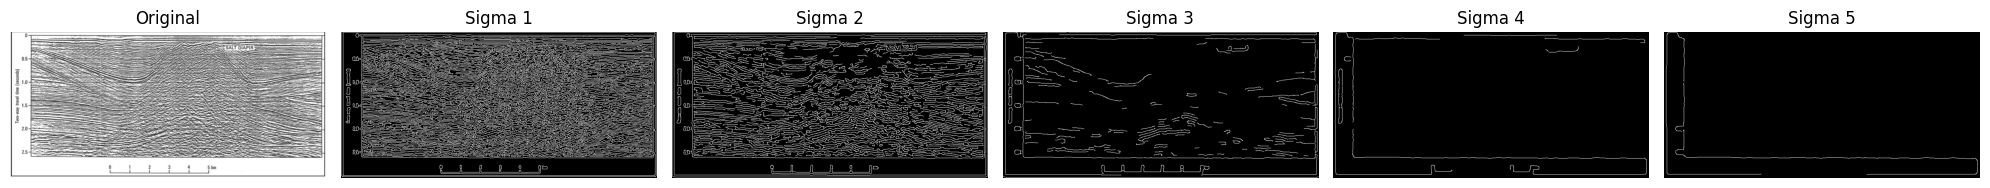

In [2]:
# Read the image from GitHub
image_url = "https://raw.githubusercontent.com/EirafWali/scikit_image/main/salt_image_seismic.jpg"
image = io.imread(image_url)

# Apply a Gaussian blur for noise reduction
image_smooth = ndi.gaussian_filter(image, sigma=1)

# Compute the Canny edges for sigma values 1 to 5 (trying different values to see the effect)
edges_sigma1 = feature.canny(image_smooth, sigma=1)
edges_sigma2 = feature.canny(image_smooth, sigma=2)
edges_sigma3 = feature.canny(image_smooth, sigma=3)
edges_sigma4 = feature.canny(image_smooth, sigma=4)
edges_sigma5 = feature.canny(image_smooth, sigma=5)

# Display the original and edge-detected images all together for comparison
# Figure 1
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(edges_sigma1, cmap='gray')
ax[1].set_title('Sigma 1')
ax[1].axis('off')

ax[2].imshow(edges_sigma2, cmap='gray')
ax[2].set_title('Sigma 2')
ax[2].axis('off')

ax[3].imshow(edges_sigma3, cmap='gray')
ax[3].set_title('Sigma 3')
ax[3].axis('off')

ax[4].imshow(edges_sigma4, cmap='gray')
ax[4].set_title('Sigma 4')
ax[4].axis('off')

ax[5].imshow(edges_sigma5, cmap='gray')
ax[5].set_title('Sigma 5')
ax[5].axis('off')

plt.tight_layout()
plt.show()


### Figure 1:

This figure is for a seismic section with salt diapirs. When sigma is set to 1, very little smoothing is applied, so the detector picks up many fine details and noise in the seismic data. As sigma increases to 2 or 3, the image becomes more blurred, and only stronger, larger-scale edges remain visible. By sigma 4 or 5, the image is so heavily blurred that most details are lost, leaving very few edges detected. This progression shows how adjusting sigma balances capturing fine details versus suppressing noise.

I think sigma 3 did an okay job in detecting the edges from the left side, however it lost track of the salt at the middle and then got it back from the right hand side. Overall, I find it a good detection tool, but maybe not for this image.

I was surprised of the smoothing as I didn't think of python as a tool to smooth seismic before. I think that for quick image processing I might consider it but not for big project as I would want to contol my frequencies filters myself.

### Section 2: Roberts Edge and Sobel Edge Detection Filters

In this section, I am using the same image to see two other edge detector methods which are the Roberts and Sobel.

Source of image: https://wiki.seg.org/wiki/Salt_kinematics

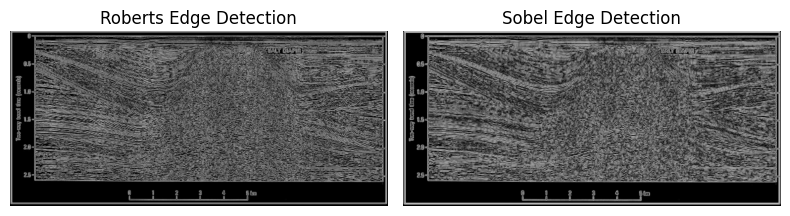

In [3]:
# Apply the Roberts edge detection filter
edge_roberts = filters.roberts(image)

# Apply the Sobel edge detection filter
edge_sobel = filters.sobel(image)

# Create a figure
# Figure 2
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

# Display the results
axes[0].imshow(edge_roberts, cmap='gray')
axes[0].set_title('Roberts Edge Detection')
axes[0].axis('off')


axes[1].imshow(edge_sobel, cmap='gray')
axes[1].set_title('Sobel Edge Detection')
axes[1].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


### Figure 2:

This figure shows the Roberts and Sobel Detection filters for the same seismic salt section used in section 1.

Roberts and Sobel both highlight the general structure of the salt diapir and layering, but they also bring out a lot of background noise in the seismic image. Roberts tends to emphasize sharper transitions but can amplify noise, while Sobel smooths the gradients slightly and produces a more continuous look at the edges.

Compared to Canny, both Roberts and Sobel are more straightforward operators that do not involve the same level of noise suppression or advanced thresholding. As a result, Canny gives cleaner edges with fewer artifacts, though it requires tuning parameters like sigma to balance fine detail and noise reduction.

Between Roberts and Sobel, the salt body seems to be more defined in Roberts Edge Detection. However, still needs smoothing for better image.

### Section 3: Morphological Snakes Segmentation

I will use this method to try and identify the fossils in an image using the segmentation.

Source of image: https://www.sciencing.com/four-types-fossils-8451633/

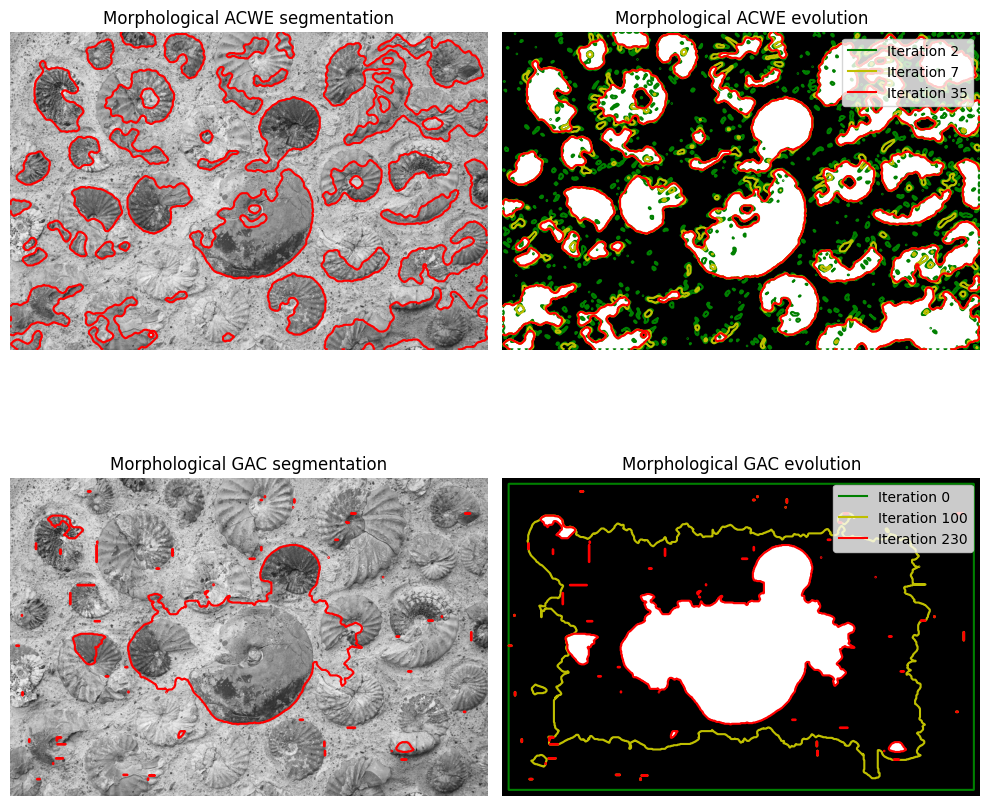

In [25]:
# To store intermediate evolution of the level sets
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in the given list."""
    def _store(x):
        lst.append(np.copy(x))
    return _store

# Use the fossils image from GitHub
fossil_url = "https://raw.githubusercontent.com/EirafWali/scikit_image/main/fossils.jpg"

# Morphological ACWE Segmentation (region-based method)
# Load the image and convert to float
image_acwe = ski.util.img_as_float(ski.io.imread(fossil_url))
# Convert to grayscale
if image_acwe.ndim == 3:
    from skimage.color import rgb2gray
    image_acwe = rgb2gray(image_acwe)

# Create an initial level set
init_ls_acwe = ski.segmentation.checkerboard_level_set(image_acwe.shape, 6)
# Prepare to store evolution sets
evolution_acwe = []
callback_acwe = store_evolution_in(evolution_acwe)

# Run the morphological Chan-Vese segmentation
ls_acwe = ski.segmentation.morphological_chan_vese(
    image_acwe,
    num_iter=35,
    init_level_set=init_ls_acwe,
    smoothing=3,
    iter_callback=callback_acwe
)

# Morphological GAC Segmentation(edge-based method)
# Load the image for GAC segmentation and convert to float
image_gac = ski.util.img_as_float(ski.io.imread(fossil_url))
# Convert to grayscale
if image_gac.ndim == 3:
    from skimage.color import rgb2gray
    image_gac = rgb2gray(image_gac)

# Compute the inverse Gaussian gradient
gimage = ski.segmentation.inverse_gaussian_gradient(image_gac)

# Create an initial level set: a centered rectangle
init_ls_gac = np.zeros(image_gac.shape, dtype=np.int8)
init_ls_gac[10:-10, 10:-10] = 1
# Prepare to store evolution sets
evolution_gac = []
callback_gac = store_evolution_in(evolution_gac)

# Run the morphological Geodesic Active Contour segmentation
ls_gac = ski.segmentation.morphological_geodesic_active_contour(
    gimage,
    num_iter=230,
    init_level_set=init_ls_gac,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
    iter_callback=callback_gac,
)

# Plot the results
# Figure 3

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.flatten()

# ACWE: Display final segmentation on the original image
ax[0].imshow(image_acwe, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls_acwe, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

# ACWE Evolution: Show a few intermediate contours from evolution
ax[1].imshow(ls_acwe, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Morphological ACWE evolution", fontsize=12)
acwe_contour_labels = []
for n, col in ((2, 'g'), (7, 'y'), (35, 'r')):
    if n < len(evolution_acwe):
        ax[1].contour(evolution_acwe[n], [0.5], colors=col)
        legend_line = mlines.Line2D([], [], color=col, label=f"Iteration {n}")
        acwe_contour_labels.append(legend_line)
ax[1].legend(handles=acwe_contour_labels, loc="upper right")

# GAC: Display final segmentation on the original image
ax[2].imshow(image_gac, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls_gac, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

# GAC Evolution: Show a few intermediate contours from evolution
ax[3].imshow(ls_gac, cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("Morphological GAC evolution", fontsize=12)
gac_contour_labels = []
for n, col in ((0, 'g'), (100, 'y'), (230, 'r')):
    if n < len(evolution_gac):
        ax[3].contour(evolution_gac[n], [0.5], colors=col)
        legend_line = mlines.Line2D([], [], color=col, label=f"Iteration {n}")
        gac_contour_labels.append(legend_line)
ax[3].legend(handles=gac_contour_labels, loc="upper right")

fig.tight_layout()
plt.show()


### Figure 3:

The segmentation results from both the ACWE (Active Contours Without Edges) and GAC (Geodesic Active Contours) methods effectively highlight the primary ammonite fossil in the center but miss the smaller fossils around it. ACWE, based on region-based segmentation, focuses on areas with similar intensity. This method works well for homogeneous regions, but struggles with lower-contrast fossils. On the other hand, GAC depend on image gradients to guide the contour toward the edges, effectively capturing the distinct boundary of the ammonite. While both methods successfully isolate the largest fossil in the image, smaller fossils are missed due to similar intensity levels or lacking pronounced boundaries. These results demonstrate how contour-based segmentation methods excel at detecting prominent objects while requiring fine-tuning to handle more complex or subtle features.

Overall, I prefer the ACWE method because it captured more of the smaller fossils in the image compared to the GAC method. ACWE's region-based approach is relies less on the sharp edges, which allows for detecting subtle intensity variations that represent smaller fossil details. This lead to a more comprehensive segmentation of the fossil content in the image provided, including both the prominant and less pronounced features




### Section 4: Hysteresis thresholding

Here I try to use Hysteresis thresholding to define the trilobites in a picture.

source of the image: https://www.scientificamerican.com/article/supercomputer-scours-fossil-record-for-earths-hidden-extinctions/

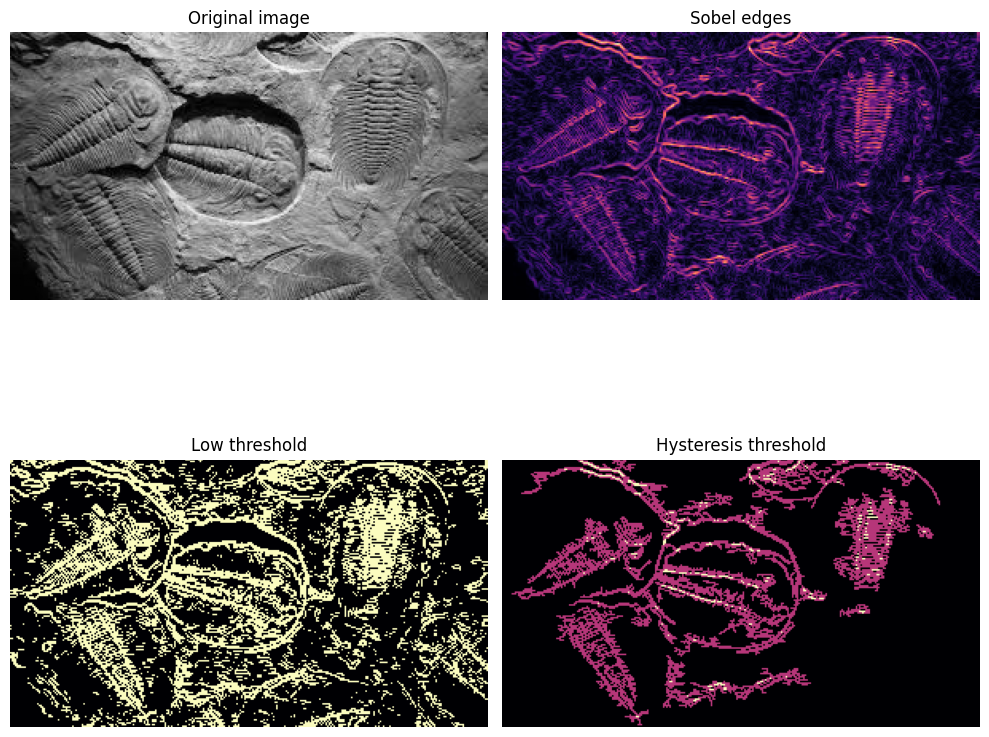

In [35]:
# Figure 4

# Create the figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Load the trilobites image from GitHub
url = "https://raw.githubusercontent.com/EirafWali/scikit_image/main/trilobites.jpg"
image = io.imread(url)

# Convert to grayscale
if image.ndim == 3:
    image = color.rgb2gray(image)

# Compute the Sobel edges
edges = filters.sobel(image)

# Set thresholds
low = 0.1
high = 0.35

# Create binary masks using the low and high thresholds
lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)

# Apply the hysteresis thresholding
hyst = filters.apply_hysteresis_threshold(edges, low, high)

# Plot the original image
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

# Plot the Sobel edges using a magma colormap
ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

# Plot the low threshold binary mask
ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

# Plot the combined high threshold and hysteresis result
ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

# Turn off the axis for all subplots
for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
plt.show()

### Figure 4

In the top left , we see the original trilobite image in grayscale, revealing the texture and anatomical details of multiple fossils embedded in a rock. The next panel applies the Sobel filter to highlight the intensity changes in the image. This filter calculates the gradient of pixel values in both horizontal and vertical directions, which reveals bright outlines wherever there is a steep change from dark to light. In this case, the edges of the trilobite shells become more apparent, as well as other surface textures.

In the Low threshold panel, we have a binary image showing all areas where the Sobel magnitude exceeds a relatively modest cutoff of 0.1. This yields a dense edge map, capturing even subtle intensity transitions. While it includes significant detail, it can also incorporate noise or weak edges that may not be geologically meaningful.

Finally, the Hysteresis threshold panel uses two thresholds (0.1 and 0.35) to refine which edges are kept. Any pixel above the higher threshold is definitely considered an edge, while pixels between the two thresholds are classified as edges only if they connect to a pixel above the higher threshold. This approach helps preserve continuous edges while discarding isolated, low-contrast segments. The result is a cleaner outline of each trilobite, preserving strong boundaries without retaining excessive noise.

### Section 5: Calibrating Denoisers Using J-Invariance

In this section I use the seismic section again to test the Calibrating Denoisers Using J-Invariance.

source of image: https://wiki.seg.org/wiki/Salt_kinematics

In [43]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.1 MB/s eta 0:00:00


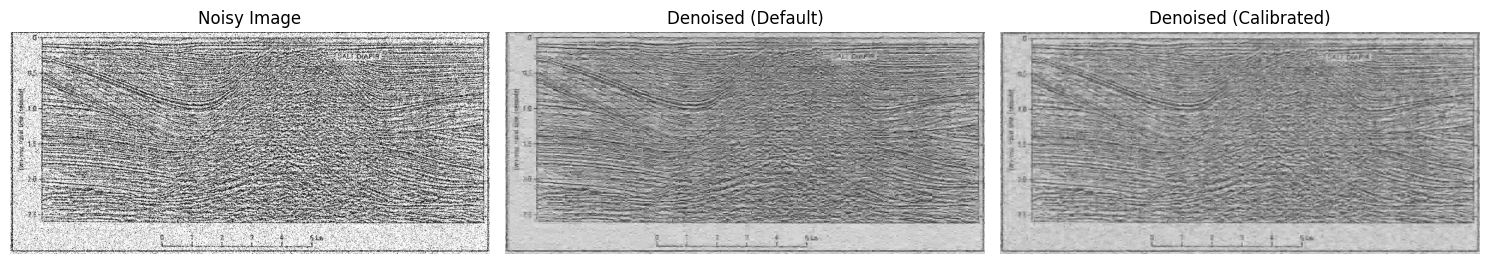

In [46]:
# Figure 5

# Use partial with rescale_sigma=True to avoid deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)

# Load the salt seismic image from GitHub
url = "https://raw.githubusercontent.com/EirafWali/scikit_image/main/salt_image_seismic.jpg"
image = img_as_float(io.imread(url))

# Introduce noise to the image with sigma=0.3
sigma = 0.3
noisy = random_noise(image, var=sigma**2)

# Define parameter ranges for calibrating the denoiser.
# Since the image is grayscale, we use channel_axis=None and skip convert2ycbcr.
parameter_ranges = {
    'sigma': np.arange(0.1, 0.3, 0.02),
    'wavelet': ['db1', 'db2'],
    'convert2ycbcr': [False],
    'channel_axis': [None],
}

# Denoise using the default parameters of denoise_wavelet
default_output = denoise_wavelet(noisy, channel_axis=None, rescale_sigma=True)

# Calibrate the denoiser using the defined parameter ranges
calibrated_denoiser = calibrate_denoiser(noisy, _denoise_wavelet, denoise_parameters=parameter_ranges)
calibrated_output = calibrated_denoiser(noisy)

# Display the results: noisy image, default denoised output, and calibrated denoised output
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
titles = ['Noisy Image', 'Denoised (Default)', 'Denoised (Calibrated)']
for ax, img, title in zip(axes, [noisy, default_output, calibrated_output], titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


### Figure 5

In the first panel, we see the seismic image after artificially adding noise with sigma=0.3. The random speckle makes it harder to interpret the subtle reflections and boundaries. In the middle, the default wavelet denoiser has reduced some of the noise, but fine features may still appear grainy or slightly blurred. On the right, the calibrated denoiser has tuned parameters (e.g., sigma range, wavelet type) to better match the noise characteristics in the image, resulting in a cleaner output. Notice that while there is still some residual texture, the calibrated version generally preserves more of the meaningful seismic reflectors while reducing random noise compared to the default approach. This illustrates how parameter optimization—especially for wavelet-based denoising—can yield better clarity for seismic data, potentially aiding interpretation.

### Reflection
I really enjoyed exploring both the Canny edge detector on my seismic image and the Morphological Snakes approach on the fossils image. Canny gave me a straightforward method for detecting strong boundaries in the seismic section, this could be useful in future seismic work for identifying salt boundaries or faults quickly. Meanwhile, Morphological Snakes, though it required more parameter tuning, felt more sophisticated and versatile when applied to the fossil image, especially if one needs to segment shapes with irregular or subtle boundaries. It was fascinating to see how the level set evolved over iterations, zeroing in on the most prominent features in the fossil. Some parts of the code were confusing at first, especially the callback function for the snake’s evolution storing, but once I understood how each iteration refined the contour, I saw how powerful it could be for detailed segmentation tasks. Both methods have the potential for more advanced geoscience applications, from horizon picking in seismic data to fossil identification in paleontological images.